# RADAR HUMAN

RADAR rules:
- the sensor cannot be too short, let's say the minimum is 36 bp
- a short sensor can be rescued with a "split" sequence, say 36 bp + 54 bp. The longer split part can be either up or downstream; the longest I tested had a gap of 1956 bp and downstream; the better one was 381 bp, and upstream
- we can utilize both CDS and 3' UTR sequences, but CDSs are less good as targets
- minimum GC can be 35%

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import json
import gzip
from io import StringIO
import multiprocessing
import os
import glob
import re
import random
matplotlib.rc("figure", dpi=160)
TABLEAU_10 = {  # new version
    "light teal": "#76B7B2",
    "red": "#E15759",
    "blue": "#4E79A7",
    "orange": "#F28E2B",
    "green": "#59A14F",
    "yellow": "#EDC948",
    "purple": "#B07AA1",
    "pink": "#FF9DA7",
    "brown": "#9C755F",
    "light gray": "#BAB0AC",
}
matplotlib.rcParams["axes.prop_cycle"] = plt.cycler(color=list(TABLEAU_10.values()))
plt.rcParams.update({'font.sans-serif': 'Arial'})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'font.sans-serif': 'Arial'})

In [3]:
import radar

GENOME = radar.FA_GENOME
MART_CDS_EXPORT = radar.MART_EXPORT_CDS
MART_3UTR_EXPORT = radar.MART_EXPORT
PREFIX = "human/"
ORGANISM = "human"

In [4]:
by_gene_cds = radar.get_by_gene_from_mart_export(mart_export=MART_CDS_EXPORT)
by_gene_3utr = radar.get_by_gene_from_mart_export(mart_export=MART_3UTR_EXPORT)

all_genes = set(by_gene_cds) | set(by_gene_3utr)

# remove entries with no CDS/3' UTR. keep miRNAs
no_cds = [gene for gene in all_genes if len(by_gene_cds.get(gene, {})) == 0 and not gene.lower().startswith("mir")]
no_utr = [gene for gene in all_genes if len(by_gene_3utr.get(gene, {})) == 0 and not gene.lower().startswith("mir")]
no_cds_no_3utr = set(no_cds) & set(no_utr)
print(len(no_cds_no_3utr))
for gene in no_cds:
    if gene in by_gene_cds:
        del by_gene_cds[gene]
for gene in no_utr:
    if gene in by_gene_3utr:
        del by_gene_3utr[gene]
all_genes = set(by_gene_cds) | set(by_gene_3utr)
no_cds = [gene for gene in all_genes if len(by_gene_cds.get(gene, {})) == 0]
no_utr = [gene for gene in all_genes if len(by_gene_3utr.get(gene, {})) == 0]
no_cds_no_3utr = set(no_cds) & set(no_utr)
print(len(no_cds), len(no_utr), len(no_cds_no_3utr))

169
136 6341 0


In [5]:
tx_cts_cds = Counter([len(txs) for gene, txs in by_gene_cds.items()])
tx_cts_cds[0] += len(no_cds)
for num in range(11):
    print(f"{num}\t{tx_cts_cds[num]}\t{tx_cts_cds[num] / len(all_genes):.1%}")
print("")
print(f"{sum([v for k, v in tx_cts_cds.items() if k >= 5])} have >= 5 CDSs")
print(f"{len(by_gene_cds)} genes in total")
print(f"{len(by_gene_cds) - tx_cts_cds[0]} genes have CDS annotation")
print(f"{tx_cts_cds[0] / len(all_genes):.1%} of genes have no CDS annotation")

0	136	0.5%
1	5954	23.5%
2	2559	10.1%
3	1930	7.6%
4	1715	6.8%
5	1575	6.2%
6	1397	5.5%
7	1245	4.9%
8	1100	4.3%
9	1006	4.0%
10	867	3.4%

13082 have >= 5 CDSs
25240 genes in total
25104 genes have CDS annotation
0.5% of genes have no CDS annotation


In [6]:
tx_cts_3utr = Counter([len(txs) for gene, txs in by_gene_3utr.items()])
tx_cts_3utr[0] += len(no_utr)
for num in range(11):
    print(f"{num}\t{tx_cts_3utr[num]}\t{tx_cts_3utr[num] / len(all_genes):.1%}")
print("")
print(f"{sum([v for k, v in tx_cts_3utr.items() if k >= 5])} have >= 5 3' UTRs")
print(f"{len(by_gene_3utr)} genes in total")
print(f"{len(by_gene_3utr) - tx_cts_3utr[0]} genes have 3' UTR annotation")
print(f"{tx_cts_3utr[0] / len(all_genes):.1%} of genes have no 3' UTR annotation")

0	6341	25.0%
1	3874	15.3%
2	3532	13.9%
3	2852	11.2%
4	2224	8.8%
5	1667	6.6%
6	1253	4.9%
7	827	3.3%
8	687	2.7%
9	422	1.7%
10	346	1.4%

6553 have >= 5 3' UTRs
19035 genes in total
12694 genes have 3' UTR annotation
25.0% of genes have no 3' UTR annotation


In [5]:
utr_genes = set(by_gene_3utr.keys())
cds_genes = set(by_gene_cds.keys())
common = utr_genes & cds_genes
utr_only = utr_genes - cds_genes
cds_only = cds_genes - utr_genes
print(len(utr_genes), len(cds_genes))
print(len(common), len(utr_only), len(cds_only))

19035 25240
18899 136 6341


In [8]:
# map gene names to list of (transcript id, transcript sequence)
tx_seqs_3utr = dict((gene, [(entry.id.split("|")[3], str(entry.seq)) for entry in entries.values()]) for gene, entries in by_gene_3utr.items())
tx_seqs_cds  = dict((gene, [(entry.id.split("|")[3], str(entry.seq)) for entry in entries.values()]) for gene, entries in by_gene_cds.items())

# Analyzing gene sets

In [6]:
def print_gene_prefixes(genes):
    prefixes = []
    for gene in genes:
        m = re.search(r"[A-Z]+", gene.upper())
        prefixes.append(m.group(0))
    for prefix, count in Counter(prefixes).most_common(30):
        print(f"{prefix}\t{count}\t{count / len(genes):.1%}")

In [9]:
no_cds = [gene for gene in all_genes if len(by_gene_cds.get(gene, {})) == 0]
no_cds = [gene for gene in no_cds if not (gene.lower().startswith("mir") or gene.lower().startswith("sno"))]
print_gene_prefixes(no_cds)
" ".join(sorted(no_cds))

GU	41	30.1%
AC	37	27.2%
AL	17	12.5%
KP	5	3.7%
AP	4	2.9%
KU	4	2.9%
BX	4	2.9%
CU	3	2.2%
CCDC	3	2.2%
FO	3	2.2%
FAM	3	2.2%
FP	2	1.5%
ATP	2	1.5%
TCTEX	2	1.5%
CXORF	1	0.7%
G	1	0.7%
ARMC	1	0.7%
MAP	1	0.7%
TTC	1	0.7%
B	1	0.7%


'AC004556.3 AC004593.2 AC007325.1 AC007325.2 AC007325.4 AC008770.4 AC010255.2 AC011043.2 AC011295.2 AC011841.1 AC022414.1 AC023491.2 AC024940.6 AC026369.8 AC037482.2 AC037482.3 AC069544.1 AC090517.4 AC093512.2 AC131160.1 AC133551.1 AC136352.2 AC136612.1 AC136616.1 AC139677.1 AC140504.1 AC145212.1 AC171558.1 AC171558.3 AC213203.2 AC226593.1 AC236040.1 AC240274.1 AC241640.1 AC243733.1 AC244489.2 AC254945.2 AL133414.1 AL133414.2 AL133414.3 AL133414.4 AL133414.5 AL133414.6 AL160269.1 AL353579.1 AL354761.1 AL354822.1 AL391987.2 AL441992.2 AL445238.1 AL445989.1 AL513523.9 AL603764.2 AL662796.1 AP000812.4 AP002495.1 AP006285.2 AP006621.6 ARMC4 ATP5MD ATP5MPL B3GNT10 BX004987.1 BX072566.1 BX276092.9 BX664615.2 CCDC114 CCDC151 CCDC58 CU464060.1 CU633846.1 CU639417.1 CXorf56 FAM122A FAM122B FAM122C FO681492.1 FO681492.2 FO681507.1 FP565260.1 FP565260.3 G6PC GU182339.1 GU182343.1 GU182343.2 GU182345.1 GU182345.2 GU182345.3 GU182345.4 GU182347.1 GU182347.2 GU182347.3 GU182347.4 GU182347.5 GU182347

In [10]:
no_utr = [gene for gene in all_genes if len(by_gene_3utr.get(gene, {})) == 0]
no_utr = [gene for gene in no_utr if not (gene.lower().startswith("mir") or gene.lower().startswith("sno"))]
print_gene_prefixes(no_utr)
" ".join(sorted(no_utr))

LINC	2130	53.7%
OR	112	2.8%
FAM	91	2.3%
IGHV	60	1.5%
C	60	1.5%
TRAJ	57	1.4%
TRBV	51	1.3%
IGKV	47	1.2%
TRAV	45	1.1%
MT	37	0.9%
IGHD	35	0.9%
IGLV	35	0.9%
TTTY	33	0.8%
USP	30	0.8%
RNVU	27	0.7%
SNHG	27	0.7%
RNU	24	0.6%
SCARNA	24	0.6%
RNA	22	0.6%
ZNF	20	0.5%
DEFB	14	0.4%
TRBJ	14	0.4%
TMEM	14	0.4%
CASC	13	0.3%
HCG	13	0.3%
TAF	13	0.3%
TRGV	9	0.2%
GOLGA	9	0.2%
PCAT	8	0.2%
CCDC	8	0.2%


'5S_rRNA 5_8S_rRNA 7SK A3GALT2 AATBC ACAP2-IT1 ADCY6-DT AFDN-DT AFF2-IT1 AFF4-DT AGAP1-IT1 AGAP11 AGBL4-IT1 AGBL5-IT1 AGK-DT AKAP1-DT AKT3-IT1 ALG9-IT1 ALMS1-IT1 AMMECR1-IT1 ANK3-DT ANKH-DT ANKRD10-IT1 ANKRD44-IT1 ANKRD60 ANKRD63 ANP32C AOAH-IT1 APCDD1L-DT APP-DT APTR ARFGEF1-DT ARHGAP22-IT1 ARHGAP26-IT1 ARHGEF38-IT1 ARHGEF7-IT1 ARHGEF9-IT1 ARLNC1 ARNILA ASAP1-IT2 ASH1L-IT1 ASTL ASXL3-DT ATG10-IT1 ATP11AUN ATP2B2-IT1 ATP2B2-IT2 ATP5MJ ATP5MK ATP6AP1L ATP6V0D1-DT B3GALT9 B3GAT1-DT BACE2-IT1 BACH1-IT1 BACH1-IT2 BACH1-IT3 BAGE2 BAIAP2-DT BANCR BARX1-DT BBS7-DT BCAR4 BCYRN1 BECN2 BGLT3 BIRC8 BISPR BLACE BMPR1B-DT BMS1P4-AGAP5 BOLA3-AS1 BPESC1 BRWD1-IT1 BSN-DT BTF3-DT BTNL10 C10orf55 C11orf40 C11orf72 C12orf77 C14orf177 C14orf178 C15orf32 C15orf54 C15orf56 C16orf95-DT C16orf97 C17orf102 C17orf114 C17orf77 C18orf12 C18orf15 C19orf48 C1orf147 C1orf195 C1orf21-DT C1orf220 C1orf229 C20orf181 C20orf197 C22orf24 C22orf34 C22orf46 C2orf27A C2orf49-DT C2orf83 C2orf91 C3orf35 C3orf36 C3orf86 C5orf17

In [11]:
no_cds_no_utr = set(no_cds) & set(no_utr)  # miRNAs ignored here
len(no_cds_no_utr)

0

# Functions

In [7]:
confs = []
for variant in "CCA", "TCA", "GCA", "CAA":
    for length in 90, 72, 36:
        confs.append((variant, length, "CDS"))
        confs.append((variant, length, "3UTR"))
confs.append(("NNN", 54, "3UTR"))
for conf in confs:
    print(conf)

('CCA', 90, 'CDS')
('CCA', 90, '3UTR')
('CCA', 72, 'CDS')
('CCA', 72, '3UTR')
('CCA', 36, 'CDS')
('CCA', 36, '3UTR')
('TCA', 90, 'CDS')
('TCA', 90, '3UTR')
('TCA', 72, 'CDS')
('TCA', 72, '3UTR')
('TCA', 36, 'CDS')
('TCA', 36, '3UTR')
('GCA', 90, 'CDS')
('GCA', 90, '3UTR')
('GCA', 72, 'CDS')
('GCA', 72, '3UTR')
('GCA', 36, 'CDS')
('GCA', 36, '3UTR')
('CAA', 90, 'CDS')
('CAA', 90, '3UTR')
('CAA', 72, 'CDS')
('CAA', 72, '3UTR')
('CAA', 36, 'CDS')
('CAA', 36, '3UTR')
('NNN', 54, '3UTR')


In [8]:
def combine_candidates(list_of_candidates_by_gene, by_gene):
    candidates_by_gene = defaultdict(list)
    seen_candidates = set()
    for this_candidates_by_gene in list_of_candidates_by_gene:
        for gene, candidates in this_candidates_by_gene.items():
            if gene not in by_gene:
                continue
            if gene.lower().startswith("mir"):  # ignore miRNAs even if there are candidates
                continue
            for c in candidates:
                if not c["bad_blast"] and c["candidate"] not in seen_candidates:
                    candidates_by_gene[gene].append(c)
                    seen_candidates.add(c["candidate"])
    return candidates_by_gene

MIRNA_NUM   =  999999
NO_3UTR_NUM = 9999999


def analyze_candidates_by_gene(by_gene_cds, candidates_by_gene, fname, utr_genes=None, exclude_non3utrs=True, verbose=True):
    n_genes = len(by_gene_cds)
    count_set = set(by_gene_cds.keys())
    mirs = set(gene for gene in by_gene_cds.keys() if gene.lower().startswith("mir"))
    if exclude_non3utrs:
        assert utr_genes is not None
        count_set &= set(utr_genes)
    count_set -= mirs  # don't count miRNAs
    n_utr_genes = len(count_set)
    cts = Counter([
        len([c for c in candidates if not c["bad_blast"]])
        for gene, candidates in candidates_by_gene.items()
        if gene in count_set
    ])
    cts[MIRNA_NUM] = len(mirs)
    cts[NO_3UTR_NUM] = 0
    if exclude_non3utrs:
        cts[NO_3UTR_NUM] = n_genes - n_utr_genes
    cts[0] = n_0 = n_genes - (sum(cts.values()) - cts[0])
    df = pd.DataFrame({"num": cts.keys(), "ct": cts.values()})
    df = df.sort_values("num").reset_index(drop=True)
    df["frac_all_genes"] = df["ct"] / n_genes
    df["frac_genes_with_utr"] = df["ct"] / n_utr_genes
    df.loc[df.shape[0] - 2, "frac_genes_with_utr"] = 0  # miRNAs
    df.loc[df.shape[0] - 1, "frac_genes_with_utr"] = 0  # no 3' UTR
    df.loc[0, "frac_genes_with_utr"] = 1 - df.frac_genes_with_utr.iloc[1:].sum()
    
    n_one_plus = df[(df.num >= 1) & (df.num < MIRNA_NUM)].ct.sum()
    n_five_plus = df[(df.num >= 5) & (df.num < MIRNA_NUM)].ct.sum()
    if verbose:
        assert df.iloc[0].num == 0
        print(f"{df.iloc[-2].ct} == {len(mirs)} miRNAs are {len(mirs) / n_genes:.1%} of the dataset")
        print(
            f"{n_0} with 0 candidates ({df.iloc[0].frac_all_genes:.1%}) of all genes, "
            f"{df.iloc[0].frac_genes_with_utr:.1%} of genes with annotated 3' UTRs)"
        )
        print(
            f"{n_one_plus} with 1+ candidates ({n_one_plus / n_genes:.1%} of all genes, "
            f"{n_one_plus / n_utr_genes:.1%} of genes with annotated 3' UTRs)"
        )
        print(
            f"{n_five_plus} have >= 5 candidates ({n_five_plus / n_genes:.1%} of all genes, "
            f"{n_five_plus / n_utr_genes:.1%} of genes with annotated 3' UTRs)"
        )
    if verbose:
        print(df.head(11))
        print(df.tail(3))
    df.to_csv(fname, index=False)
    return df


def write_candidates_by_gene(candidates_by_gene, fname):
    serialized = {}
    for gene, candidates in candidates_by_gene.items():
        serialized[gene] = []
        for candidate in candidates:
            candidate = candidate.copy()
            candidate["blast_results"] = "" # candidate["blast_results"].to_csv(index=False)
            candidate["bad_blast"] = bool(candidate["bad_blast"])
            serialized[gene].append(candidate)
    with gzip.open(fname, "wt", encoding="UTF-8") as fp:
        json.dump(serialized, fp, indent=True)


def read_candidates_by_gene(json_fname, blast_fname=None):
    with gzip.open(json_fname) as fp:
        candidates_by_gene = json.load(fp)
    if blast_fname is not None:
        try:
            df = pd.read_csv(blast_fname)
        except pd.errors.ParserError as e:
            print(blast_fname, "couldn't be loaded")
            raise e
        gb = df.groupby("seq")
        for gene, candidates in candidates_by_gene.items():
            for candidate in candidates:
                candidate["blast_results"] = gb.get_group(candidate["sensor"])
    return candidates_by_gene


def annotate_transcripts_covered(candidates_by_gene):
    for gene, candidates in candidates_by_gene.items():
        for candidate in candidates:
            candidate["matches"] = set()
            tx_seqs = tx_seqs_3utr.get(gene, [])
            if candidate["region_type"].startswith("CDS"):
                tx_seqs = tx_seqs_cds.get(gene, [])
            for seq_id, seq in tx_seqs:
                if candidate["candidate"] in seq:
                    candidate["matches"].add(seq_id)
            candidate["matches"] = sorted(candidate["matches"])


left_right = {
    36: (18, 15),
    54: (24, 27),
    72: (33, 36),
    90: (42, 45),
}


def analyze_variant_and_length(variant, length, by_gene, verbose=True, threads=12, prefix="", suffix="", tx_cts=None, max_candidates_rand=None, force=False):
    blast_fname = f"{prefix}{variant}_{length}_candidates_by_gene{suffix}.csv.gz"
    if not force and os.path.isfile(blast_fname):
        # print(f"skipping because {blast_fname} exists")
        return
    res = {}
    left, right = left_right[length]
    if verbose:
        print(variant, length, left + right + 3)
    res["by_gene"], res["candidates_by_gene"], res["blast_results"] = radar.look_at_all_mart_genes(
        by_gene=by_gene, variants=(variant,), left=left, right=right, min_match=25,
        verbose=verbose, threads=threads, max_candidates_rand=max_candidates_rand,
    )
    res["candidates_by_gene"] = combine_candidates([res["candidates_by_gene"]], by_gene)  # to apply blast filter
    write_candidates_by_gene(res["candidates_by_gene"], f"{prefix}{variant}_{length}_candidates_by_gene{suffix}.json.gz")
    res["blast_results"].to_csv(blast_fname + ".tmp.csv.gz", index=False)
    os.rename(blast_fname + ".tmp.csv.gz", blast_fname)


def process_split_cbg(core_candidates_by_gene, nnn_candidates_by_gene, length, region_type):
    cbg = {}
    random.seed(42)
    for gene, candidates in core_candidates_by_gene.items():
        nnns = nnn_candidates_by_gene.get(gene, [])
        nnns_by_seq_id = defaultdict(list)
        for nnn in nnns:
            for seq_id in nnn["matches"]:
                nnns_by_seq_id[seq_id].append(nnn)
        if not len(nnns):
            continue
        new_candidates = []
        for this_candidate in candidates:
            have_seqs = set()
            for seq_id in this_candidate["matches"]:  # consider all transcript versions this candidate is on
                if nnns_by_seq_id[seq_id]:
                    candidate = this_candidate.copy()
                    nnn = random.choice(nnns_by_seq_id[seq_id])  # pick random NNN partner to pair with that's on the same transcript
                    # CDS-3UTR means the core is in the CDS, with the rest (nnn) in the 3' UTR.
                    # we don't consider 3UTR-CDS, but could in theory. the core would be in the 3' UTR and the rest in the CDS
                    # 3UTR-3UTR means both the core and the rest are in the 3' UTR.
                    # if our sensor is core + nnn, then the candidate should be nnn + core on the transcript.
                    #   this works for 3UTR-3UTR (core + nnn), provided nnn is before core in the transcript
                    #   this works for 3UTR-CDS (core + nnn)
                    # if it's instead nnn + core, then the candidate should be core + nnn
                    #   this works for CDS-3UTR if we don't want a pretzel
                    #   this does not work for 3UTR-CDS
                    #   this works for 3UTR-3UTR, provided that the nnn is after the core
                    if region_type == "3UTR-3UTR":
                        # make sure that the nnn partner is after the core in the transcript.
                        # the start and end keys are for the candidate trigger sequence.
                        if nnn["start"] < candidate["end"]:
                            continue
                    candidate["sensor"] = nnn["sensor"] + candidate["sensor"]
                    if candidate["sensor"] in have_seqs:
                        continue
                    have_seqs.add(candidate["sensor"])
                    candidate["candidate"] = candidate["candidate"] + "..." + nnn["candidate"]
                    candidate["length"] = length
                    candidate["region_type"] = region_type
                    candidate["matches"] = sorted(set(candidate["matches"]) & set(nnn["matches"]))
                    candidate["longest_homopolymer"], candidate["total_homopolymer"] = radar.eval_for_homopolymers(candidate["sensor"])
                    nt_counts = Counter(candidate["sensor"])
                    candidate["GC"] = round((nt_counts["G"] + nt_counts["C"]) / len(candidate["sensor"]), 2)
                    new_candidates.append(candidate)
                    if len(new_candidates) == 5:  # arbitrary limit to stop this from blowing up
                        break
        if len(new_candidates):
            cbg[gene] = new_candidates
    random.seed(None)
    return cbg


def write_candidate_table(candidates_by_gene, fname):
    rows = []
    for gene, candidates in candidates_by_gene.items():
        for candidate in candidates:
            row = {}
            for k in (
                "gene", "gene_id", "variant", "length", "region_type", "sensor", "candidate",
                "sensor_tln", "GC", "longest_homopolymer", "total_homopolymer",
            ):
                row[k] = candidate[k]
            row["matches"] = ";".join(candidate["matches"])
            rows.append(row)
    df = pd.DataFrame(rows)
    df.sort_values(
        ["gene", "length", "region_type", "variant", "GC"],
        ascending=[True, False, True, False, False], inplace=True,
    )
    print(f"writing {df.shape[0]} candidates")
    print(df.gene.nunique(), "unique genes")
    df.to_csv(fname, index=False)


def draw_pie(ax, df, top=5, start=1, label_size=15, field="frac_genes_with_utr"):
    groups = []
    for i in range(top):
        groups.append(f"{i}-{i}")
    groups.append(f"{i + 1}-inf")
    return draw_pie_grouped(ax, df, groups=groups, label_size=label_size, field=field)


def draw_pie_grouped(ax, df, groups=("0-0", "1-1", "2-5", "6-10", "11-inf"), label_size=15, field="frac_genes_with_utr"):
    labels, yy = [], []
    for g in groups:
        left, right = map(float, g.split("-"))
        label = g
        if left == right:
            label = f"{left:.0f}"
        if right == float("inf"):
            label = f"{left:.0f}+"
        labels.append(label)
        yy.append(df[(df.num >= left) & (df.num <= right) & (df.num < MIRNA_NUM)][field].sum())
    cycler = plt.rcParams["axes.prop_cycle"]()
    colors = [next(cycler)["color"] for _ in range(len(labels))]
    if field != "frac_genes_with_utr":
        y = df[df.num == MIRNA_NUM][field].sum()
        labels.append("miRNAs")
        yy.append(y)
        colors.append("white")
        
        y = df[df.num == NO_3UTR_NUM][field].sum()
        if y:
            labels.append("Without\n3' UTR")
            yy.append(y)
            colors.append("#eeeeee")
    print(labels, yy, sum(yy))
    patches, texts, autotexts = ax.pie(
        yy, labels=labels, autopct="%.1f", pctdistance=0.7, counterclock=False, colors=colors,
        startangle=180, textprops=dict(fontsize=label_size), labeldistance=1.15, normalize=False,
    )
    for t in texts:
        t.set_fontsize(label_size)
    return patches, texts, autotexts

# Generating data

In [26]:
# generating sensors in chunks of genes for given designs
n = 50  # genes per chunk
threads = 11  # chunks in parallel

by_gene_chunks = []
prng = np.random.RandomState(42)
genes = sorted(by_gene_cds)[::-1]
prng.shuffle(genes)
for variant, length, seq_type in confs:
    for i in range(0, len(genes), n):
        this_genes = genes[i:i + n]
        this_by_gene = {}
        for gene in this_genes:
            this_by_gene[gene] = by_gene_cds[gene] if seq_type == "CDS" else by_gene_3utr.get(gene, {})
        by_gene_chunks.append((i, this_by_gene, variant, length, seq_type))


def analyze(by_gene_chunk):
    i, this_by_gene, variant, length, seq_type = by_gene_chunk
    if seq_type == "CDS":
        prefix = PREFIX + "CDS/CDS_"
    else:
        prefix = PREFIX
    analyze_variant_and_length(
        variant, length, by_gene=this_by_gene, verbose=False, threads=1,
        tx_cts=tx_cts_cds if seq_type == "CDS" else tx_cts_3utr,
        max_candidates_rand=100 if variant == "NNN" else None,
        prefix=prefix, suffix=f"_chunk_{i}_{i + n}",
    )


with multiprocessing.Pool(threads) as p:
    list(tqdm.tqdm(p.imap(analyze, by_gene_chunks), total=len(by_gene_chunks), leave=True))

100%|██████████| 12625/12625 [01:40<00:00, 125.52it/s]


In [27]:
# combining chunks
for variant, length, seq_type in confs:
    if seq_type == "CDS":
        prefix = PREFIX + "CDS/CDS_"
    else:
        prefix = PREFIX
    blast_fname = f"{prefix}{variant}_{length}_candidates_by_gene.csv.gz"
    if os.path.isfile(blast_fname):
        print(f"have {blast_fname}")
        continue
    files = glob.glob(f"{prefix}{variant}_{length}_candidates_by_gene_chunk*.json.gz")
    cbgs = []
    for f in tqdm.tqdm(files, leave=True):
        cbg = read_candidates_by_gene(f, f.replace(".json.gz", ".csv.gz"))
        cbgs.append(cbg)
    combined_cbg = combine_candidates(cbgs, by_gene_cds)
    annotate_transcripts_covered(combined_cbg)
    for gene, candidates in combined_cbg.items():
        for cand in candidates:
            cand["gene"] = gene
            cand["gene_id"] = cand["source_description"].split("|")[0]
            cand["length"] = length
            cand["region_type"] = seq_type
    write_candidates_by_gene(combined_cbg, f"{prefix}{variant}_{length}_candidates_by_gene.json.gz")
    dfs = []
    for gene, candidates in combined_cbg.items():
        dfs.extend([c["blast_results"] for c in candidates])
    df = pd.concat(dfs)
    df.to_csv(blast_fname, index=False)
    print(variant, length, seq_type)

have human/CDS/CDS_CCA_90_candidates_by_gene.csv.gz
have human/CCA_90_candidates_by_gene.csv.gz
have human/CDS/CDS_CCA_72_candidates_by_gene.csv.gz
have human/CCA_72_candidates_by_gene.csv.gz
have human/CDS/CDS_CCA_36_candidates_by_gene.csv.gz
have human/CCA_36_candidates_by_gene.csv.gz
have human/CDS/CDS_TCA_90_candidates_by_gene.csv.gz
have human/TCA_90_candidates_by_gene.csv.gz
have human/CDS/CDS_TCA_72_candidates_by_gene.csv.gz
have human/TCA_72_candidates_by_gene.csv.gz
have human/CDS/CDS_TCA_36_candidates_by_gene.csv.gz
have human/TCA_36_candidates_by_gene.csv.gz


  0%|          | 2/505 [00:00<00:32, 15.27it/s]

GCA 90 CDS


  0%|          | 0/505 [00:00<?, ?it/s]

GCA 90 3UTR


  0%|          | 2/505 [00:00<00:25, 19.37it/s]

GCA 72 CDS


  0%|          | 0/505 [00:00<?, ?it/s]

GCA 72 3UTR


  0%|          | 0/505 [00:00<?, ?it/s]

GCA 36 CDS


  0%|          | 2/505 [00:00<00:33, 14.92it/s]

GCA 36 3UTR


  1%|          | 3/505 [00:00<00:21, 23.84it/s]

CAA 90 CDS


  0%|          | 1/505 [00:00<00:54,  9.18it/s]

CAA 90 3UTR


  0%|          | 2/505 [00:00<00:35, 14.29it/s]

CAA 72 CDS


  0%|          | 0/505 [00:00<?, ?it/s]

CAA 72 3UTR


  0%|          | 1/505 [00:00<00:54,  9.26it/s]

CAA 36 CDS


  0%|          | 0/505 [00:00<?, ?it/s]

CAA 36 3UTR


100%|██████████| 505/505 [03:50<00:00,  2.19it/s]


NNN 54 3UTR


# Load data

In [10]:
all_candidates_by_gene = {}
for variant, length, transcript_type in tqdm.tqdm(confs, leave=True):
    # print(variant, length, transcript_type)
    prefix = "CDS/CDS_" if transcript_type == "CDS" else ""
    candidates_by_gene = read_candidates_by_gene(
        PREFIX + f"{prefix}{variant}_{length}_candidates_by_gene.json.gz",
        None, #  f"{prefix}{variant}_{length}_candidates_by_gene.csv.gz",  # skip loading blast results
    )
    all_candidates_by_gene[(variant, length, transcript_type)] = candidates_by_gene

100%|██████████| 25/25 [01:41<00:00,  4.06s/it]


# Before expansion

In [20]:
# in this figure, we just show 90 bp UTR sensors: CCA, GCA, TCA, CAA
combined_pre_expansion_fig = combine_candidates([
    all_candidates_by_gene[(variant, 90, "3UTR")] for variant in ("CCA", "GCA", "TCA", "CAA")
], by_gene_cds)

In [21]:
df = analyze_candidates_by_gene(
    by_gene_cds, combined_pre_expansion_fig, PREFIX + "combined_pre_expansion_fig.csv", utr_genes=common,
    exclude_non3utrs=True, verbose=True,
)

1925.0 == 1925 miRNAs are 7.6% of the dataset
2502 with 0 candidates (9.9%) of all genes, 23.4% of genes with annotated 3' UTRs)
14472 with 1+ candidates (57.3% of all genes, 76.6% of genes with annotated 3' UTRs)
10262 have >= 5 candidates (40.7% of all genes, 54.3% of genes with annotated 3' UTRs)
    num    ct  frac_all_genes  frac_genes_with_utr
0     0  2502        0.099128             0.234245
1     1  1378        0.054596             0.072914
2     2  1095        0.043384             0.057940
3     3   901        0.035697             0.047674
4     4   836        0.033122             0.044235
5     5   793        0.031418             0.041960
6     6   699        0.027694             0.036986
7     7   610        0.024168             0.032277
8     8   542        0.021474             0.028679
9     9   505        0.020008             0.026721
10   10   446        0.017670             0.023599
         num    ct  frac_all_genes  frac_genes_with_utr
136      230     1        0.000

In [ ]:
print(df[(df.num > 0) & (df.num < MIRNA_NUM)].ct.sum())
print(df[(df.num > 0) & (df.num < MIRNA_NUM)].frac_all_genes.sum())

In [22]:
df.ct.sum(), len(by_gene_cds)

(25240, 25240)

In [23]:
df.frac_all_genes.sum()

1.0

In [24]:
df.frac_genes_with_utr.sum()

1.0

In [25]:
len(common)

18899

In [35]:
len(by_gene_cds) - len(common)

6341

In [26]:
len(common) / len(by_gene_cds)

0.7487717908082409

['0', '1', '2', '3', '4', '5+', 'miRNAs', "Without\n3' UTR"] [0.0991283676703645, 0.05459587955625991, 0.04338351822503962, 0.0356973058637084, 0.03312202852614897, 0.4065768621236133, 0.07626782884310618, 0.2512282091917591] 1.0


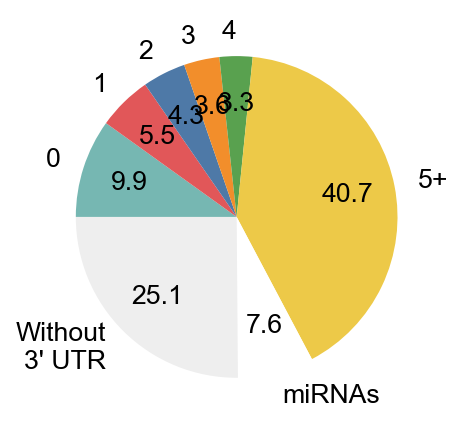

In [27]:
df = pd.read_csv(PREFIX + "combined_pre_expansion_fig.csv")
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
patches, texts, autotexts = draw_pie(ax, df, label_size=12, field="frac_all_genes")
fig.tight_layout()
fig.savefig(PREFIX + "Fig pre expansion.svg", dpi=300)

# Fig 1k

In [11]:
# here we pull all the tricks, combining CCA/GCA/TCA/CAA variants:
# - for the UTR @ 90 bp +
# - for the UTR @ 72 bp +
# - for the CDS @ 90 bp + 
# - for the CDS @ 72 bp + 
# - for the UTR @ 36 + 54 bp +
# - for the CDS @ 36 bp + 54 bp @ UTR +
combined_fig1k = combine_candidates([
    all_candidates_by_gene[(variant, 90, "3UTR")] for variant in ("CCA", "GCA", "TCA", "CAA")
] + [
    all_candidates_by_gene[(variant, 72, "3UTR")] for variant in ("CCA", "GCA", "TCA", "CAA")
] + [
    all_candidates_by_gene[(variant, 90, "CDS")] for variant in ("CCA", "GCA", "TCA", "CAA")
] + [
    all_candidates_by_gene[(variant, 72, "CDS")] for variant in ("CCA", "GCA", "TCA", "CAA")
] + [
    process_split_cbg(all_candidates_by_gene[(variant, 36, "3UTR")], all_candidates_by_gene[("NNN", 54, "3UTR")], 36 + 54, "3UTR-3UTR") for variant in ("CCA", "GCA", "TCA", "CAA")
] + [
    process_split_cbg(all_candidates_by_gene[(variant, 36, "CDS")], all_candidates_by_gene[("NNN", 54, "3UTR")], 36 + 54, "CDS-3UTR") for variant in ("CCA", "GCA", "TCA", "CAA")
], by_gene_cds)

In [12]:
write_candidate_table(combined_fig1k, f"{PREFIX}{ORGANISM}_RADAR_sensor_candidates.csv.gz")

writing 7434523 candidates
21342 unique genes


In [13]:
df = analyze_candidates_by_gene(
    by_gene_cds, combined_fig1k, PREFIX + "combined_fig1k.csv", utr_genes=common, verbose=True,
    exclude_non3utrs=False,
)

1925.0 == 1925 miRNAs are 7.6% of the dataset
1973 with 0 candidates (7.8%) of all genes, 8.5% of genes with annotated 3' UTRs)
21342 with 1+ candidates (84.6% of all genes, 91.5% of genes with annotated 3' UTRs)
20553 have >= 5 candidates (81.4% of all genes, 88.2% of genes with annotated 3' UTRs)
    num    ct  frac_all_genes  frac_genes_with_utr
0     0  1973        0.078170             0.084624
1     1   273        0.010816             0.011709
2     2   216        0.008558             0.009264
3     3   158        0.006260             0.006777
4     4   142        0.005626             0.006090
5     5   139        0.005507             0.005962
6     6   178        0.007052             0.007635
7     7   119        0.004715             0.005104
8     8   147        0.005824             0.006305
9     9   139        0.005507             0.005962
10   10   128        0.005071             0.005490
          num    ct  frac_all_genes  frac_genes_with_utr
1915    24892     1        0.00

In [14]:
print(df[(df.num > 0) & (df.num < MIRNA_NUM)].ct.sum())
print(df[(df.num > 0) & (df.num < MIRNA_NUM)].frac_all_genes.sum())

21342
0.8455625990491284


In [14]:
print(df[(df.num > 0) & (df.num < MIRNA_NUM)].ct.sum())
print(df[(df.num > 0) & (df.num < MIRNA_NUM)].frac_all_genes.sum())

21342
0.8455625990491284


In [15]:
df.ct.sum()

25240

['0', '1-5', '6-50', '51+', 'miRNAs'] [0.07816957210776546, 0.03676703645007924, 0.1562202852614897, 0.6525752773375595, 0.07626782884310618] 1.0


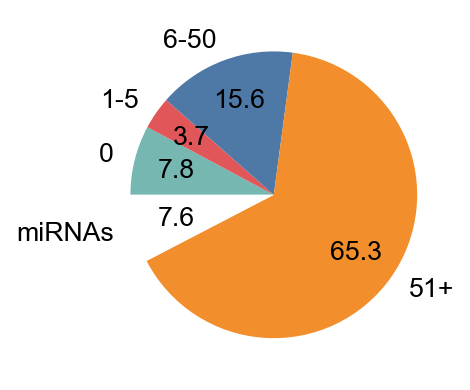

In [16]:
df = pd.read_csv(PREFIX + "combined_fig1k.csv")
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
patches, texts, autotexts = draw_pie_grouped(ax, df, groups=("0-0", "1-5", "6-50", "51-inf"), label_size=12, field="frac_all_genes")
fig.tight_layout()
fig.savefig(PREFIX + "Fig 1k.svg", dpi=300)

## Ones without any candidates

In [17]:
no_candidates = sorted([gene for gene in by_gene_cds if len(combined_fig1k.get(gene, [])) == 0 and not gene.lower().startswith("mir")])

In [18]:
len(no_candidates)

1973

In [19]:
print_gene_prefixes(no_candidates)

SNORD	273	13.8%
SNORA	133	6.7%
OR	111	5.6%
LINC	75	3.8%
IGHV	58	2.9%
TRAJ	57	2.9%
FAM	51	2.6%
IGKV	46	2.3%
MT	42	2.1%
TRBV	40	2.0%
H	38	1.9%
IGHD	37	1.9%
IGLV	33	1.7%
KRTAP	30	1.5%
USP	25	1.3%
PRAMEF	22	1.1%
TTTY	22	1.1%
DEFB	21	1.1%
RNA	19	1.0%
RNU	19	1.0%
ZNF	18	0.9%
SPDYE	16	0.8%
SCARNA	15	0.8%
CT	14	0.7%
GOLGA	14	0.7%
TRBJ	14	0.7%
GAGE	12	0.6%
TAF	12	0.6%
TRAV	12	0.6%
TRIM	12	0.6%


In [20]:
13.8+6.7

20.5

960.5562442607898


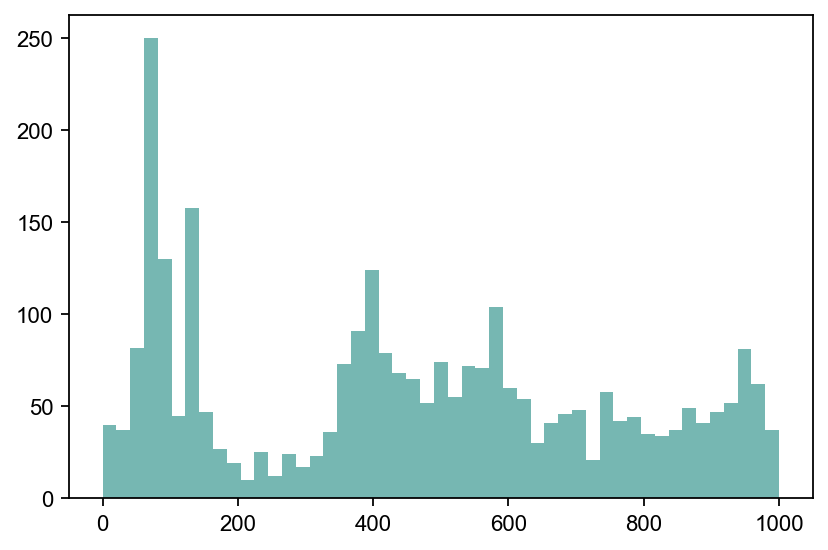

In [21]:
cds_lengths = []
for gene in no_candidates:
    for cds in by_gene_cds[gene].values():
        cds_lengths.append(len(cds.seq))
fig, ax = plt.subplots()
ax.hist(cds_lengths, bins=np.linspace(0, 1000, 50))
print(np.mean(cds_lengths))

197.74898456539398


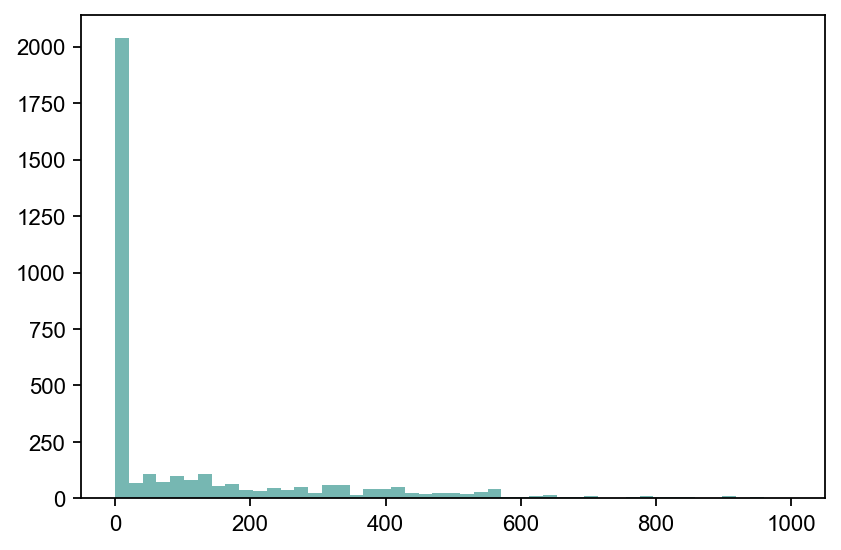

In [22]:
utr_lengths = []
for gene in no_candidates:
    utrs = by_gene_3utr.get(gene, dict()).values()
    for utr in utrs:
        utr_lengths.append(len(utr.seq))
    else:
        utr_lengths.append(0)
fig, ax = plt.subplots()
ax.hist(utr_lengths, bins=np.linspace(0, 1000, 50))
print(np.mean(utr_lengths))

# Incremental benefits

In [7]:
df = pd.read_csv(f"{PREFIX}{ORGANISM}_RADAR_sensor_candidates.csv.gz")

(90, '3UTR')	14472	+57.3%	57.3%
(72, '3UTR')	15495	+4.1%	61.4%
(90, 'CDS')	20716	+24.7%	82.1%
(72, 'CDS')	21037	+26.0%	83.3%
(90, '3UTR-3UTR')	15974	+6.0%	63.3%
(90, 'CDS-3UTR')	16777	+9.1%	66.5%


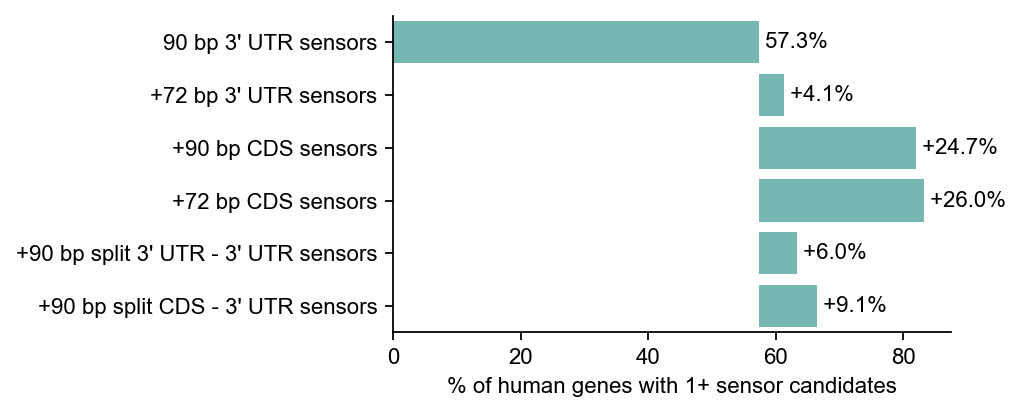

In [10]:
using_combos = []
combos = [
    (90, "3UTR"),
    (72, "3UTR"),
    (90, "CDS"),
    (72, "CDS"),
    (90, "3UTR-3UTR"),
    (90, "CDS-3UTR"),
]
n_genes = len(by_gene_cds)
gb = df.groupby(["length", "region_type"])
fig, ax = plt.subplots(figsize=(4.5, 2.62))
prev = 0
lefts = [0]
for i, combo in enumerate(combos):
    # using_combos.append(combo)
    using_combos = [combos[0], combo]
    genes = set()
    for this_combo in using_combos:
        genes |= set(gb.get_group(this_combo).gene)
    n = len(genes)
    incremental = (n - prev) / n_genes * 100
    print(f"{combo}\t{n}\t+{incremental:.1f}%\t{n / n_genes:.1%}")
    ax.barh(i, incremental, left=prev / n_genes * 100, color=TABLEAU_10["light teal"])
    ax.text(n / n_genes * 100, i, f" {'+' if i > 0 else ''}{incremental:.1f}%", verticalalignment="center")
    if i == 0:
        prev = n
ax.set_ylim(len(combos) - 0.5, -0.5)
ax.set_yticks(range(len(combos)))
ax.set_yticklabels([
    "90 bp 3' UTR sensors",
    "+72 bp 3' UTR sensors",
    "+90 bp CDS sensors",
    "+72 bp CDS sensors",
    "+90 bp split 3' UTR - 3' UTR sensors",
    "+90 bp split CDS - 3' UTR sensors",
])
ax.set_xlabel(f"% of {ORGANISM} genes with 1+ sensor candidates")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(PREFIX + "incremental benefits.svg")

(90, '3UTR')	14472	+57.3%	57.3%
(72, '3UTR')	14714	+1.0%	58.3%
(90, 'CDS')	20080	+22.2%	79.6%
(72, 'CDS')	20492	+23.9%	81.2%
(90, '3UTR-3UTR')	15504	+4.1%	61.4%
(90, 'CDS-3UTR')	16700	+8.8%	66.2%
(90, '3UTR')	11098	+44.0%	44.0%
(72, '3UTR')	11970	+3.5%	47.4%
(90, 'CDS')	17622	+25.8%	69.8%
(72, 'CDS')	18413	+29.0%	73.0%
(90, '3UTR-3UTR')	13758	+10.5%	54.5%
(90, 'CDS-3UTR')	16474	+21.3%	65.3%
(90, '3UTR')	2644	+10.5%	10.5%
(72, '3UTR')	2988	+1.4%	11.8%
(90, 'CDS')	4421	+7.0%	17.5%
(72, 'CDS')	5502	+11.3%	21.8%
(90, '3UTR-3UTR')	5938	+13.1%	23.5%
(90, 'CDS-3UTR')	14202	+45.8%	56.3%


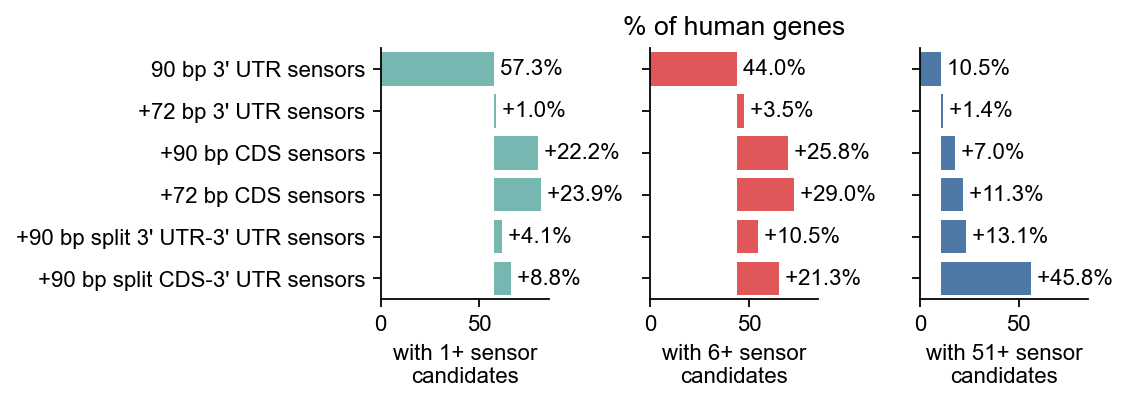

In [34]:
using_combos = []
combos = [
    (90, "3UTR"),
    (72, "3UTR"),
    (90, "CDS"),
    (72, "CDS"),
    (90, "3UTR-3UTR"),
    (90, "CDS-3UTR"),
]
n_genes = len(by_gene_cds)
gb = df.groupby(["length", "region_type"])
fig, axs = plt.subplots(1, 3, figsize=(7, 2.62), sharex=True, sharey=True)
colors = [TABLEAU_10["light teal"], TABLEAU_10["red"], TABLEAU_10["blue"]]
for j, cutoff in enumerate([1, 6, 51]):
    prev = 0
    lefts = [0]
    ax = axs[j]
    for i, combo in enumerate(combos):
        # using_combos.append(combo)
        using_combos = [combos[0], combo]
        gene_counts = 0
        for this_combo in using_combos:
            gene_counts = gb.get_group(this_combo).gene.value_counts().add(gene_counts, fill_value=0)
            # print(gene_counts.sort_values())
        n = (gene_counts > cutoff).sum()
        incremental = (n - prev) / n_genes * 100
        print(f"{combo}\t{n}\t+{incremental:.1f}%\t{n / n_genes:.1%}")
        ax.barh(i, incremental, left=prev / n_genes * 100, color=colors[j])
        ax.text(n / n_genes * 100, i, f" {'+' if i > 0 else ''}{incremental:.1f}%", verticalalignment="center")
        if i == 0:
            prev = n
    ax.set_ylim(len(combos) - 0.5, -0.5)
    ax.set_xlabel(f"with {cutoff}+ sensor\ncandidates")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
axs[1].set_title(f"% of {ORGANISM} genes")
ax = axs[0]
ax.set_yticks(range(len(combos)))
ax.set_yticklabels([
    "90 bp 3' UTR sensors",
    "+72 bp 3' UTR sensors",
    "+90 bp CDS sensors",
    "+72 bp CDS sensors",
    "+90 bp split 3' UTR-3' UTR sensors",
    "+90 bp split CDS-3' UTR sensors",
])
fig.tight_layout()
fig.savefig(PREFIX + "incremental benefits.svg")